In [1]:
# 時系列データを予測する

# お決まり設定
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [2]:
import tensorflow as tf

In [3]:
# 入力データ用のサイン関数曲線を作成
t_min, t_max = 0, 30
resolution = 0.1

def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t*5)

def next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

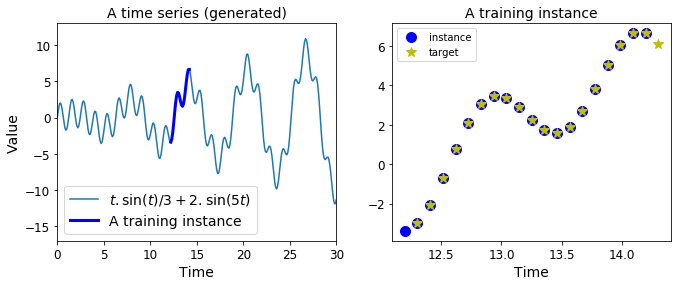

In [4]:
t = np.linspace(t_min, t_max, int((t_max - t_min) / resolution))

n_steps = 20
t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1)

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.title("A time series (generated)", fontsize=14)
plt.plot(t, time_series(t), label=r"$t . \sin(t) / 3 + 2 . \sin(5t)$")
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "b-", linewidth=3, label="A training instance")
plt.legend(loc="lower left", fontsize=14)
plt.axis([0, 30, -17, 13])
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.title("A training instance", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "y*", markersize=10, label="target")
plt.legend(loc="upper left")
plt.xlabel("Time")


plt.savefig("time_series_plot")
plt.show()
# 左グラフが時系列データ全体。右グラフが訓練データ部分を拡大したイメージ
# 下記右グラフにあるようにタイムステップの一つ先のターゲットを予測する

In [5]:
X_batch, y_batch = next_batch(1, n_steps)
# n_steps:20が入っている
# 

In [6]:
# タイムステップ1
np.c_[X_batch[0], y_batch[0]]

array([[-4.15188423, -3.6085526 ],
       [-3.6085526 , -2.56413923],
       [-2.56413923, -1.133684  ],
       [-1.133684  ,  0.47721251],
       [ 0.47721251,  2.0213009 ],
       [ 2.0213009 ,  3.26875122],
       [ 3.26875122,  4.06192999],
       [ 4.06192999,  4.35248988],
       [ 4.35248988,  4.21170648],
       [ 4.21170648,  3.81154668],
       [ 3.81154668,  3.38111934],
       [ 3.38111934,  3.14918561],
       [ 3.14918561,  3.28681933],
       [ 3.28681933,  3.86427043],
       [ 3.86427043,  4.83260637],
       [ 4.83260637,  6.0346391 ],
       [ 6.0346391 ,  7.24247415],
       [ 7.24247415,  8.21249925],
       [ 8.21249925,  8.74435882],
       [ 8.74435882,  8.72948348]])

In [7]:
# 予測結果の受け取り方 今回の予測はタイムステップ当たり一つの予測値のみしか必要ないのでOutputProjectionWrapperを使用する
# OutputProjectionWrapper
# RNNの出力シーケンスを次元削減してタイムステップ(インスタンス)あたり一つの値にする
# 戻り値入力テンソルまたは入力テンソルのリスト。

In [8]:
reset_graph()

n_steps = 20 # タイムステップ数は20
n_inputs = 1 # 予測特徴量は1つ
n_neurons = 100 # 再帰ニューロン数
n_outputs = 1 # 取得したい予測値は1つ

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

In [9]:
# OutputProjectionWrapper
# BasicRNNCellをOutputProjectionWrapperでラッピングする
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu),
    output_size=n_outputs)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.


In [10]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.


In [11]:
learning_rate = 0.001

loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [12]:
saver = tf.train.Saver()

In [13]:
n_iterations = 1500
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    saver.save(sess, "./my_time_series_model") # not shown in the book
# saver.passでモデルを保存している

0 	MSE: 10.261381
100 	MSE: 0.38792896
200 	MSE: 0.10900874
300 	MSE: 0.061354414
400 	MSE: 0.059336416
500 	MSE: 0.058288667
600 	MSE: 0.052280974
700 	MSE: 0.047044784
800 	MSE: 0.049216457
900 	MSE: 0.0473833
1000 	MSE: 0.047798716
1100 	MSE: 0.047832422
1200 	MSE: 0.041717164
1300 	MSE: 0.046195257
1400 	MSE: 0.04128444


In [14]:
# できたモデルで予測してみる。saver.restoreで保存したモデルを呼び出している
with tf.Session() as sess:                          # not shown in the book
    saver.restore(sess, "./my_time_series_model")   # not shown

    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./my_time_series_model


In [15]:
y_pred

array([[[-3.398375 ],
        [-2.4517932],
        [-1.0338113],
        [ 0.7044598],
        [ 2.2053058],
        [ 3.181232 ],
        [ 3.525914 ],
        [ 3.391311 ],
        [ 2.857527 ],
        [ 2.2694187],
        [ 1.7152514],
        [ 1.5625854],
        [ 1.9287689],
        [ 2.783921 ],
        [ 3.8925717],
        [ 5.1402655],
        [ 6.1224003],
        [ 6.676544 ],
        [ 6.722065 ],
        [ 6.0950246]]], dtype=float32)

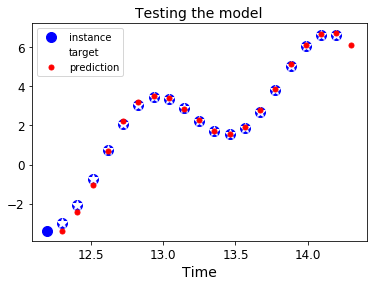

In [16]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.savefig("time_series_pred_plot")
plt.show()

In [17]:
# time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
# タイムステップの12.2(始まり)～終わりまでの実測値:yの値
# t_instance: X軸の値
# 

In [18]:
# 新しいシーケンスの作成
# ここまで作成されたモデルから次の値を予測していく新しいシーケンスを作れる
# この処理がうまくできない。グラフが全然違うものになる・・・

with tf.Session() as sess:                        # not shown in the book
    saver.restore(sess, "./my_time_series_model") # not shown

    sequence = [0.] * n_steps
    for iteration in range(300):
        X_batch = np.array(sequence[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./my_time_series_model


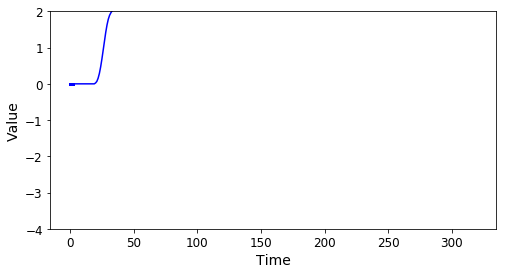

In [19]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(sequence)), sequence, "b-")
plt.plot(t[:n_steps], sequence[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")
plt.ylim(-4,2)	
plt.show()

INFO:tensorflow:Restoring parameters from ./my_time_series_model


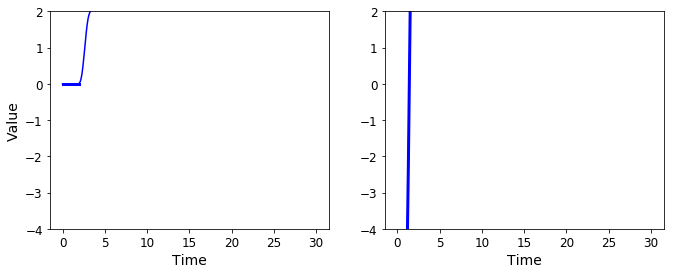

In [20]:
with tf.Session() as sess:
    saver.restore(sess, "./my_time_series_model")

    sequence1 = [0. for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence1[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence1.append(y_pred[0, -1, 0])

    sequence2 = [time_series(i * resolution + t_min + (t_max-t_min/3)) for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence2[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence2.append(y_pred[0, -1, 0])

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.plot(t, sequence1, "b-")
plt.plot(t[:n_steps], sequence1[:n_steps], "b-", linewidth=3)
plt.ylim(-4,2)
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.plot(t, sequence2, "b-")
plt.plot(t[:n_steps], sequence2[:n_steps], "b-", linewidth=3)
plt.ylim(-4,2)
plt.xlabel("Time")
plt.savefig("creative_sequence_plot")
plt.show()